In [1]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [2]:
import pip  
pip.main(['install', 'imutils'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [3]:
! pip install opencv-python

In [4]:
get_ipython().magic(u'matplotlib inline')

In [5]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale (eliminates every form of colour information and only leaves different shades of gray; the brightest being white and the darkest of it being black., and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image


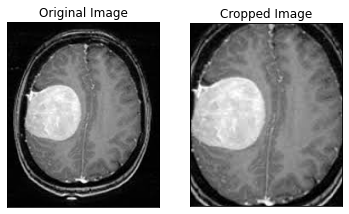

In [6]:
example_image = cv2.imread('dataset/yes/Y1.jpg')
ex_new_img = crop_brain_contour(example_image, True)

In [7]:
def load_data(dir_list, image_size):

    
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # print(image)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y

In [8]:
augmented_path = 'dataset/'

# augmented data (yes and no) contains both the original and the new generated examples of the images
datasets_yes = augmented_path + 'yes'
datasets_no  = augmented_path + 'no'
IMG_WIDTH, IMG_HEIGHT = (224, 224)
X, y = load_data([datasets_yes, datasets_no], (IMG_WIDTH, IMG_HEIGHT))

Y1.jpg
dataset/yes
Y10.jpg
dataset/yes
Y100.JPG
dataset/yes
Y101.jpg
dataset/yes
Y102.jpg
dataset/yes
Y103.jpg
dataset/yes
Y104.jpg
dataset/yes
Y105.jpg
dataset/yes
Y106.jpg
dataset/yes
Y107.jpg
dataset/yes
Y108.jpg
dataset/yes
Y109.JPG
dataset/yes
Y11.jpg
dataset/yes
Y111.JPG
dataset/yes
Y112.JPG
dataset/yes
Y113.JPG
dataset/yes
Y114.JPG
dataset/yes
Y115.JPG
dataset/yes
Y116.JPG
dataset/yes
Y117.JPG
dataset/yes
Y12.jpg
dataset/yes
Y120.JPG
dataset/yes
Y13.jpg
dataset/yes
Y14.jpg
dataset/yes
Y146.JPG
dataset/yes
Y147.JPG
dataset/yes
Y148.JPG
dataset/yes
Y15.jpg
dataset/yes
Y153.jpg
dataset/yes
Y154.jpg
dataset/yes
Y155.JPG
dataset/yes
Y156.JPG
dataset/yes
Y157.JPG
dataset/yes
Y158.JPG
dataset/yes
Y159.JPG
dataset/yes
Y16.JPG
dataset/yes
Y160.JPG
dataset/yes
Y161.JPG
dataset/yes
Y162.jpg
dataset/yes
Y163.JPG
dataset/yes
Y164.JPG
dataset/yes
Y165.JPG
dataset/yes
Y166.JPG
dataset/yes
Y167.JPG
dataset/yes
Y168.jpg
dataset/yes
Y169.jpg
dataset/yes
Y17.jpg
dataset/yes
Y170.JPG
dataset/yes
Y1

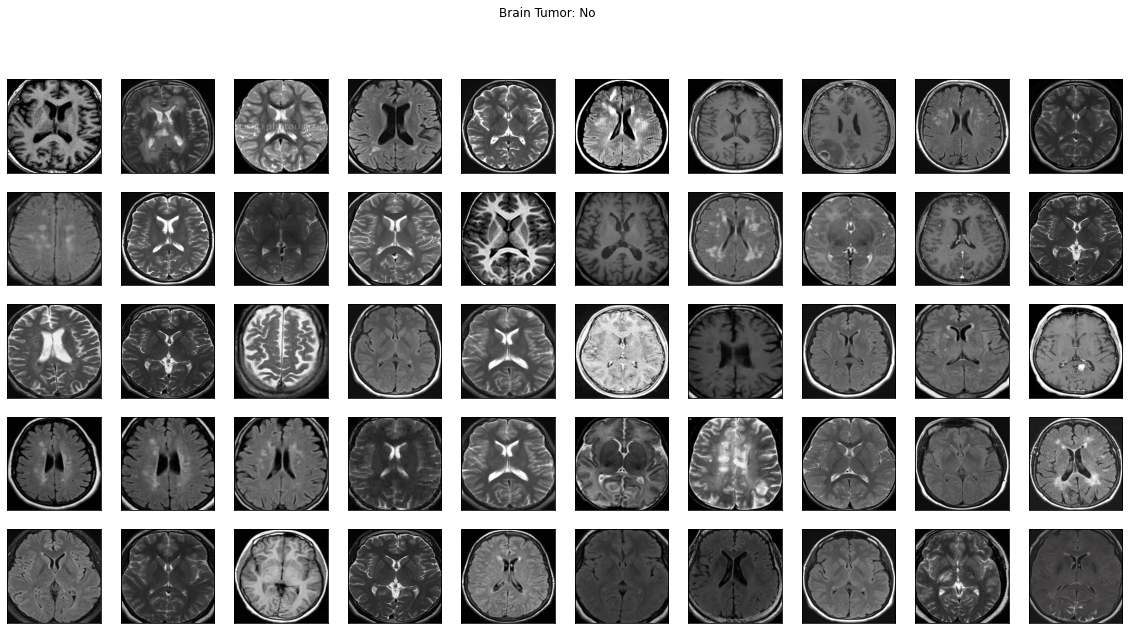

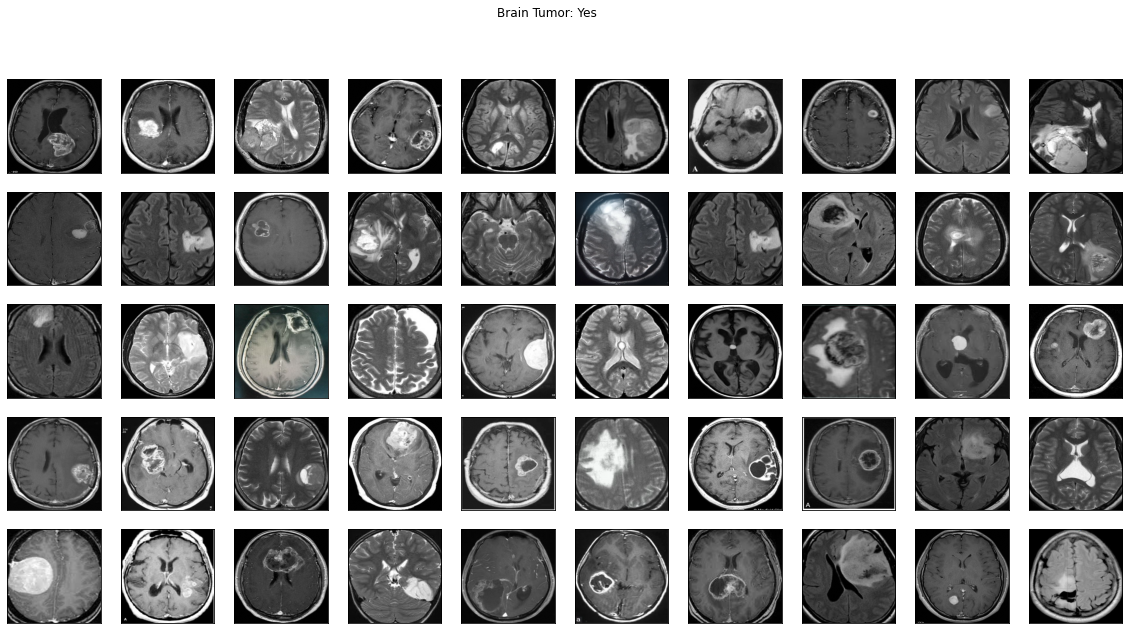

In [9]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle("Brain Tumor: {}".format(label_to_str(label)))
        plt.show()

plot_sample_images(X, y)


In [10]:
#Test,train and validate the dataset
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 224, 224, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 224, 224, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 224, 224, 3)
Y_test shape: (38, 1)


In [13]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{}:{}".format(h,m,round(s,1))

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)

    return score

In [15]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # 

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X) # 
    # X=Dropout(0.50)(X)


    X = Conv2D(128, (5, 5), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)  # shape=(?, 238, 238, 32)
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    X=Dropout(0.50)(X)

    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)


    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 222, 222, 64)      1792      
                                                                 
 bn0 (BatchNormalization)    (None, 222, 222, 64)      256       
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 111, 111, 64)      0         
                                                                 
 conv1 (Conv2D)              (None, 54, 54, 128)       204928    
                                                                 
 bn1 (BatchNormalization)    (None, 54, 54, 128

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


import time

# tensorboard
log_file_name = 'brain_tumor_detection_cnn_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_file_name))




# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [19]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[reduce_lr,tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 4.6168 - accuracy: 0.5480

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.47.model\assets
Assets written to: models\cnn-parameters-improvement-01-0.47.model\assets
6/6 [==============================] - 27s 4s/step - loss: 4.6168 - accuracy: 0.5480 - val_loss: 0.6930 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 2.1982 - accuracy: 0.6215

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-02-0.58.model\assets
6/6 [==============================] - 26s 4s/step - loss: 2.1982 - accuracy: 0.6215 - val_loss: 1.6438 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.6949

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.53.model\assets
Assets written to: models\cnn-parameters-improvement-03-0.53.model\assets
6/6 [==============================] - 25s 4s/step - loss: 1.2196 - accuracy: 0.6949 - val_loss: 0.6899 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 0.8442 - accuracy: 0.7006

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.63.model\assets
Assets written to: models\cnn-parameters-improvement-04-0.63.model\assets
6/6 [==============================] - 25s 4s/step - loss: 0.8442 - accuracy: 0.7006 - val_loss: 0.7152 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 5/30
6/6 [==============================] - ETA: 0s - loss: 0.7034 - accuracy: 0.7401

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.74.model\assets
Assets written to: models\cnn-parameters-improvement-05-0.74.model\assets
6/6 [==============================] - 26s 4s/step - loss: 0.7034 - accuracy: 0.7401 - val_loss: 0.6295 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 6/30
6/6 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.8136

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.68.model\assets
Assets written to: models\cnn-parameters-improvement-06-0.68.model\assets
6/6 [==============================] - 26s 4s/step - loss: 0.4850 - accuracy: 0.8136 - val_loss: 0.6442 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 7/30
6/6 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.8249

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.61.model\assets
Assets written to: models\cnn-parameters-improvement-07-0.61.model\assets
6/6 [==============================] - 26s 4s/step - loss: 0.4277 - accuracy: 0.8249 - val_loss: 0.6800 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 8/30
6/6 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.8870

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.66.model\assets
Assets written to: models\cnn-parameters-improvement-08-0.66.model\assets
6/6 [==============================] - 26s 4s/step - loss: 0.2847 - accuracy: 0.8870 - val_loss: 0.6619 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 9/30
6/6 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.9040

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.61.model\assets
Assets written to: models\cnn-parameters-improvement-09-0.61.model\assets
6/6 [==============================] - 26s 4s/step - loss: 0.2808 - accuracy: 0.9040 - val_loss: 0.6801 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 10/30
6/6 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8531

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-10-0.58.model\assets
6/6 [==============================] - 28s 5s/step - loss: 0.3349 - accuracy: 0.8531 - val_loss: 0.7059 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 11/30
6/6 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9040

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-11-0.58.model\assets
6/6 [==============================] - 26s 4s/step - loss: 0.2419 - accuracy: 0.9040 - val_loss: 0.7090 - val_accuracy: 0.5789 - lr: 2.0000e-04
Epoch 12/30
6/6 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9096

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-12-0.58.model\assets
6/6 [==============================] - 27s 4s/step - loss: 0.2238 - accuracy: 0.9096 - val_loss: 0.7076 - val_accuracy: 0.5789 - lr: 2.0000e-04
Epoch 13/30
6/6 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.8927

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-13-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.2287 - accuracy: 0.8927 - val_loss: 0.7184 - val_accuracy: 0.5789 - lr: 2.0000e-04
Epoch 14/30
6/6 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9040

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-14-0.58.model\assets
6/6 [==============================] - 28s 5s/step - loss: 0.2069 - accuracy: 0.9040 - val_loss: 0.7605 - val_accuracy: 0.5789 - lr: 2.0000e-04
Epoch 15/30
6/6 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9153

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-15-0.58.model\assets
6/6 [==============================] - 28s 5s/step - loss: 0.2225 - accuracy: 0.9153 - val_loss: 0.7414 - val_accuracy: 0.5789 - lr: 2.0000e-04
Epoch 16/30
6/6 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.8870

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-16-0.58.model\assets
6/6 [==============================] - 28s 5s/step - loss: 0.2448 - accuracy: 0.8870 - val_loss: 0.7296 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 17/30
6/6 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9096

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-17-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.2310 - accuracy: 0.9096 - val_loss: 0.7637 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 18/30
6/6 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9435

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-18-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.1705 - accuracy: 0.9435 - val_loss: 0.7804 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 19/30
6/6 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.9096

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-19-0.58.model\assets
6/6 [==============================] - 28s 5s/step - loss: 0.2109 - accuracy: 0.9096 - val_loss: 0.7662 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 20/30
6/6 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.9209

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-20-0.58.model\assets
6/6 [==============================] - 28s 5s/step - loss: 0.1713 - accuracy: 0.9209 - val_loss: 0.7451 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 21/30
6/6 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.8927

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-21-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-21-0.58.model\assets
6/6 [==============================] - 27s 4s/step - loss: 0.2142 - accuracy: 0.8927 - val_loss: 0.7588 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 22/30
6/6 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9435

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-22-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-22-0.58.model\assets
6/6 [==============================] - 27s 4s/step - loss: 0.1726 - accuracy: 0.9435 - val_loss: 0.7701 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 23/30
6/6 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9040

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-23-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-23-0.58.model\assets
6/6 [==============================] - 27s 4s/step - loss: 0.2130 - accuracy: 0.9040 - val_loss: 0.7886 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 24/30
6/6 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9322

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-24-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-24-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.1803 - accuracy: 0.9322 - val_loss: 0.7876 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 25/30
6/6 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9435

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-25-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-25-0.58.model\assets
6/6 [==============================] - 26s 4s/step - loss: 0.1846 - accuracy: 0.9435 - val_loss: 0.7770 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 26/30
6/6 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9435

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-26-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-26-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.1497 - accuracy: 0.9435 - val_loss: 0.7634 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 27/30
6/6 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9266

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-27-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-27-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.1958 - accuracy: 0.9266 - val_loss: 0.7909 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 28/30
6/6 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9153

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-28-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-28-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.1744 - accuracy: 0.9153 - val_loss: 0.8144 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 29/30
6/6 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9435

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-29-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-29-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.1858 - accuracy: 0.9435 - val_loss: 0.8338 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 30/30
6/6 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9492

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-30-0.58.model\assets
Assets written to: models\cnn-parameters-improvement-30-0.58.model\assets
6/6 [==============================] - 27s 5s/step - loss: 0.1581 - accuracy: 0.9492 - val_loss: 0.7989 - val_accuracy: 0.5789 - lr: 1.0000e-04
Elapsed time: 0:13:24.0


In [20]:
history = model.history.history

for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy
lr


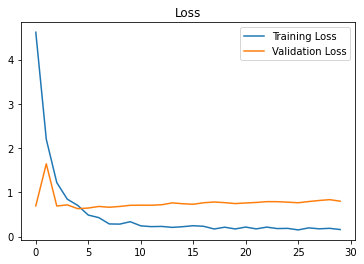

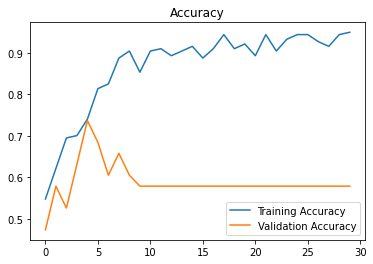

In [21]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()




plot_metrics(history)

In [22]:
model.metrics_names

['loss', 'accuracy']

In [23]:
loss, accuracy = model.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 1s 229ms/step - loss: 0.5377 - accuracy: 0.7105


In [24]:
print ("Test Loss = {}".format(loss))
print ("Test Accuracy = {}".format(accuracy))

Test Loss = 0.5377492308616638
Test Accuracy = 0.7105262875556946


In [25]:
y_test_prob = model.predict(X_test)

2/2 [==============================] - 1s 219ms/step


In [26]:
f1score = compute_f1_score(y_test, y_test_prob)

In [27]:
y_val_prob = model.predict(X_val)

2/2 [==============================] - 1s 226ms/step


In [28]:
f1score_val = compute_f1_score(y_val, y_val_prob)

In [29]:
def datasets_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [30]:
datasets_percentage(y)

Number of examples:253
Percentage of positive examples: 61.26482213438735%, number of pos examples: 155
Percentage of negative examples: 38.73517786561265%, number of neg examples: 98


In [31]:
print("Training Data:")
datasets_percentage(y_train)
print("Validation Data:")
datasets_percentage(y_val)
print("Testing Data:")
datasets_percentage(y_test)

Training Data:
Number of examples:177
Percentage of positive examples: 59.887005649717516%, number of pos examples: 106
Percentage of negative examples: 40.112994350282484%, number of neg examples: 71
Validation Data:
Number of examples:38
Percentage of positive examples: 57.89473684210526%, number of pos examples: 22
Percentage of negative examples: 42.10526315789474%, number of neg examples: 16
Testing Data:
Number of examples:38
Percentage of positive examples: 71.05263157894737%, number of pos examples: 27
Percentage of negative examples: 28.94736842105263%, number of neg examples: 11


In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))

In [33]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  50
hidden_nodes_layer2 = 33
hidden_nodes_layer3 = 25
hidden_nodes_layer4 = 15

nn1 = tf.keras.models.Sequential()

# First hidden layer
nn1.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid")
)


# Second hidden layer
nn1.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))


# Output layer
nn1.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))


# Check the structure of the model
nn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                7526450   
                                                                 
 dense_1 (Dense)             (None, 33)                1683      
                                                                 
 dense_2 (Dense)             (None, 1)                 34        
                                                                 
Total params: 7,528,167
Trainable params: 7,528,167
Non-trainable params: 0
_________________________________________________________________


In [34]:
nn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# Train the model
fit_model = nn1.fit(X_train,y_train,epochs=60)

Epoch 1/60
6/6 [==============================] - 1s 120ms/step - loss: 0.7274 - accuracy: 0.4350
Epoch 2/60
6/6 [==============================] - 1s 121ms/step - loss: 0.6965 - accuracy: 0.5198
Epoch 3/60
6/6 [==============================] - 1s 128ms/step - loss: 0.6783 - accuracy: 0.5989
Epoch 4/60
6/6 [==============================] - 1s 126ms/step - loss: 0.6747 - accuracy: 0.5989
Epoch 5/60
6/6 [==============================] - 1s 123ms/step - loss: 0.6763 - accuracy: 0.5989
Epoch 6/60
6/6 [==============================] - 1s 125ms/step - loss: 0.6769 - accuracy: 0.5989
Epoch 7/60
6/6 [==============================] - 1s 122ms/step - loss: 0.6768 - accuracy: 0.5989
Epoch 8/60
6/6 [==============================] - 1s 125ms/step - loss: 0.6736 - accuracy: 0.5989
Epoch 9/60
6/6 [==============================] - 1s 128ms/step - loss: 0.6734 - accuracy: 0.5989
Epoch 10/60
6/6 [==============================] - 1s 124ms/step - loss: 0.6742 - accuracy: 0.5989
Epoch 11/60
6/6 [==

In [70]:
from keras.models import Sequential
def create_model(neurons=1, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

param_grid = {
    'neurons': [8, 16, 32, 64],
    'activation': ['relu', 'sigmoid']
}

In [71]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

C:\Users\Personel\AppData\Local\Temp/ipykernel_17576/2369240914.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10)


In [72]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/10
12/12 [==============================] - 1s 25ms/step - loss: 0.9318 - accuracy: 0.6102
Epoch 2/10
12/12 [==============================] - 0s 26ms/step - loss: 0.6903 - accuracy: 0.5508
Epoch 3/10
12/12 [==============================] - 0s 25ms/step - loss: 0.6764 - accuracy: 0.6017
Epoch 4/10
12/12 [==============================] - 0s 30ms/step - loss: 0.6452 - accuracy: 0.6102
Epoch 5/10
12/12 [==============================] - 0s 29ms/step - loss: 0.5948 - accuracy: 0.6102
Epoch 6/10
12/12 [==============================] - 0s 30ms/step - loss: 0.5335 - accuracy: 0.6525
Epoch 7/10
12/12 [==============================] - 0s 31ms/step - loss: 0.5571 - accuracy: 0.7712
Epoch 8/10
12/12 [==============================] - 0s 26ms/step - loss: 0.4456 - accuracy: 0.8220
Epoch 9/10
12/12 [==============================] - 0s 24ms/step - loss: 0.4105 - accuracy: 0.8220
Epoch 10/10
6/6 [==============================] - 0s 5ms/step - loss: 0.6579 - accuracy: 0.6102
Epoch 1/10
1

12/12 [==============================] - 0s 37ms/step - loss: 0.6751 - accuracy: 0.6102
Epoch 3/10
12/12 [==============================] - 0s 39ms/step - loss: 0.6731 - accuracy: 0.6102
Epoch 4/10
12/12 [==============================] - 0s 40ms/step - loss: 0.6722 - accuracy: 0.6102
Epoch 5/10
12/12 [==============================] - 0s 39ms/step - loss: 0.6695 - accuracy: 0.6102
Epoch 6/10
12/12 [==============================] - 0s 39ms/step - loss: 0.6700 - accuracy: 0.6102
Epoch 7/10
12/12 [==============================] - 0s 39ms/step - loss: 0.6692 - accuracy: 0.6102
Epoch 8/10
12/12 [==============================] - 0s 40ms/step - loss: 0.6690 - accuracy: 0.6102
Epoch 9/10
12/12 [==============================] - 0s 39ms/step - loss: 0.6692 - accuracy: 0.6102
Epoch 10/10
6/6 [==============================] - 0s 6ms/step - loss: 0.6837 - accuracy: 0.5763
Epoch 1/10
12/12 [==============================] - 1s 35ms/step - loss: 0.7968 - accuracy: 0.4576
Epoch 2/10
12/12 [=====

In [73]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.649718 using {'activation': 'relu', 'neurons': 32}
